In [1]:
import random
import math
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas as pd
from sklearn.preprocessing import normalize

import os
from IPython.display import clear_output

%matplotlib inline

In [2]:
def eigsort(V, eigvals): 
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

# normc(M) normalizes the columns of M to a length of 1.
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [3]:
# import rawdata as numpy
rawdata = pd.read_csv('data/rating_cleaned_update.csv')
rawdata = rawdata.to_numpy(dtype=int)

In [4]:
# Randomly seperate rawdata into training and testing based on the user id. 80:20 split
ids = list(set(rawdata[:,0]))
num_users = len(ids)
random.shuffle(ids)
split = int(len(ids) * 0.8)
train_id = np.sort(ids[:split])
test_id = np.sort(ids[split:])
ids = np.sort(ids)
num_train_user = len(train_id)
num_test_user = len(test_id)
print(num_users, num_train_user, num_test_user)
print(ids, train_id, test_id)

54004 43203 10801
[    3     5     7 ... 73512 73513 73515] [    3     7     8 ... 73512 73513 73515] [    5    11    18 ... 73501 73502 73506]


In [5]:
# Base on the user id split, split the dataset as well.
train_data = []
test_data = []
train_index = 0
test_index = 0
for i in rawdata:
    if i[0] > train_id[train_index] and train_index < len(train_id)-1:
        train_index += 1
    if i[0] > test_id[test_index] and test_index < len(test_id)-1:
        test_index += 1
    
    if i[0] == train_id[train_index]:
        train_data.append(i)
    elif i[0] == test_id[test_index]:
        test_data.append(i)
    else:
        print("Error " + str(i[0]))

In [6]:
# Calculate the average score for each anime in the trainning set
average_dict = {}
for i in train_data:
    if i[1] in average_dict.keys():
        average_dict[i[1]][0] += i[2]
        average_dict[i[1]][1] += 1
    else:
        average_dict[i[1]] = [i[2], 1]
for i in average_dict.keys():
    average_dict[i] = average_dict[i][0]/average_dict[i][1]
num_anime = len(average_dict)
print(num_anime)

2815


In [7]:
# Some dictionary that can look up the id with index or index with id
user_idx_to_id = {idx: i for idx, i in enumerate(train_id)}
user_id_to_idx = {i: idx for idx, i in enumerate(train_id)}
anime_idx_to_id = {idx: i for idx, i in enumerate(average_dict.keys())}
anime_id_to_idx = {i: idx for idx, i in enumerate(average_dict.keys())}
# An array with average score of each anime according to the index of anime
average_anime = np.array([average_dict[i] for idx, i in enumerate(average_dict.keys())])

In [8]:
# Make training metrix, contains users rating - mean rating, note that if a user doesn't score one anime, 
# then it by default use the average
average_arr = np.ones((num_train_user, num_anime)) * average_anime
anime_user_arr = average_arr.copy()
for i in train_data:
    anime_user_arr[user_id_to_idx[i[0]],anime_id_to_idx[i[1]]] = i[2]
anime_user_arr -= average_arr

In [9]:
# Calculate the covariance matrix
covMat = np.matmul(anime_user_arr.transpose(), anime_user_arr)
divMat = anime_user_arr.copy()
divMat[divMat != 0] = 1
divMat = np.matmul(divMat.transpose(), divMat)
divMat[divMat == 0] = 1
covMat = np.divide(covMat, divMat)
print(covMat.shape)

(2815, 2815)


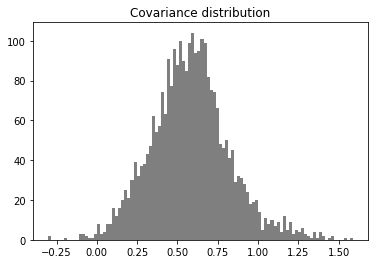

In [10]:
# Draw the covariance matrix distrbution
cov_values = []
for i in range(1,len(covMat)):
    cov_values.append(covMat[0][i])

num_bins = 100
plt.title("Covariance distribution")
n, bins, patches = plt.hist(cov_values, num_bins, facecolor='black', alpha=0.5)
plt.show()

In [11]:
# Calculate the eigenvalues and eigenvectors
eigvals, V = np.linalg.eig(covMat)
print(V.shape)

(2815, 2815)


In [12]:
# Sort the eigenvalues and eigenectors
V, eigvals = eigsort(V, eigvals)

In [13]:
# Use the first user to regenerate
C = np.matmul(V.transpose(), anime_user_arr[0,:])

In [14]:
# Calculate the first user's regenerated matrix
R = np.matmul(V[:,:], C[:]) + average_anime

In [15]:
# Print and see there are no difference
print(R)
print(anime_user_arr[0] + average_anime)

[8.         6.         9.         ... 7.12222222 7.20245399 7.36585366]
[8.         6.         9.         ... 7.12222222 7.20245399 7.36585366]


In [16]:
# Now reshuffle train data
index_list = [i for i in range(len(train_data))]
random.shuffle(index_list)

In [17]:
# Take out one rating of each user and get a new train not enough information to calculate error
train_error_arr = average_arr.copy()
train_MSE_arr = []
met = set()
for i in index_list:
    one_data = train_data[i]
    if not one_data[0] in met:
        met.add(one_data[0])
        train_MSE_arr.append(one_data)
    else:
        train_error_arr[user_id_to_idx[one_data[0]],anime_id_to_idx[one_data[1]]] = one_data[2]
train_error_arr -= average_arr
print(train_error_arr.shape)

(43203, 2815)


In [18]:
# Calculate the regenerating matrix
C = np.matmul(V.transpose(), train_error_arr.transpose())
print(C.shape)

(2815, 43203)


In [20]:
# Try different number of top array, and obtain the one with smallest error 
lowest = 0
lowest_value = 2
top_arr = [1, 10, 20, 50, 100, 150, 200, 500, 1000, 2000]
# Use all the data above to regenerate
for i in top_arr:
    # Calculate all users' regenerated matrix, use only top n eigenvectors
    R = np.matmul(V[:,:i], C[:i]).transpose() + average_arr
    # Calculate the difference between newly regenerated matrix and the hidden scores, this is training error
    R[R > 10] = 10
    R[R < 1] = 1
    difference = 0
    total = 0
    for j in train_MSE_arr:
        difference += (R[user_id_to_idx[j[0]],anime_id_to_idx[j[1]]] - j[2]) ** 2
        total += 1
    mse = difference/total
    rmse = math.sqrt(mse)
    if rmse < lowest_value:
        lowest_value = rmse
        lowest = i
    print(str(i) + ": " + str(mse) + " " + str(rmse))

1: 1.9324868454884572 1.3901391460887853
10: 1.9153519187898314 1.3839623978959223
20: 1.8975767459351327 1.3775255881235502
50: 1.8757072756317499 1.3695646299579112
100: 1.85001656556667 1.3601531404833318
150: 1.8289693955057107 1.35239394981851
200: 1.810894770717231 1.345694902538176
500: 1.728614978622434 1.3147680322484396
1000: 1.673613218272003 1.29368203909307
2000: 2.0108348903218576 1.418039100420668


In [21]:
# Try different number of factor, and obtain the one with smallest error 
factor = 0
factor_value = 2
factors = [float(i) for i in range(10)]
# Use all the data above to regenerate
for i in factors:
    # Calculate all users' regenerated matrix, use only top n eigenvectors
    R = np.matmul(V[:,:lowest], C[:lowest]).transpose() * i + average_arr
    # Calculate the difference between newly regenerated matrix and the hidden scores, this is training error
    R[R > 10] = 10
    R[R < 1] = 1
    difference = 0
    total = 0
    for j in train_MSE_arr:
        difference += (R[user_id_to_idx[j[0]],anime_id_to_idx[j[1]]] - j[2]) ** 2
        total += 1
    mse = difference/total
    rmse = math.sqrt(mse)
    if rmse < factor_value:
        factor_value = rmse
        factor = i
    print(str(i) + ": " + str(mse) + " " + str(rmse))

0.0: 1.9636151578016785 1.4012905329736864
1.0: 1.673613218272003 1.29368203909307
2.0: 1.4802485775962995 1.2166546665329072
3.0: 1.374966982738264 1.172589861263632
4.0: 1.3434835377829624 1.1590873727993771
5.0: 1.3716472439681797 1.1711734474313271
6.0: 1.4455977528963564 1.2023301347368602
7.0: 1.5544696120924109 1.246783707020753
8.0: 1.689491688372521 1.2998044808249127
9.0: 1.8451669874182905 1.3583692382479406


In [22]:
# Now calculate the test error, first prepare dictionary that can look up in testing set
test_user_idx_to_id = {idx: i for idx, i in enumerate(test_id)}
test_user_id_to_idx = {i: idx for idx, i in enumerate(test_id)}

In [23]:
# randomly shuffle test dataset
index_list = [i for i in range(len(test_data))]
random.shuffle(index_list)

In [24]:
# Do the same as above to the test dataset
test_average_arr = np.ones((num_test_user, num_anime)) * average_anime
test_error_arr = test_average_arr.copy()
test_MSE_arr = []
met = set()
for i in index_list:
    one_data = test_data[i]
    if not one_data[0] in met:
        met.add(one_data[0])
        test_MSE_arr.append(one_data)
    else:
        test_error_arr[test_user_id_to_idx[one_data[0]],anime_id_to_idx[one_data[1]]] = one_data[2]
test_error_arr -= test_average_arr
print(test_error_arr.shape)
print(len(test_MSE_arr))

(10801, 2815)
10801


In [25]:
C = np.matmul(V.transpose(), test_error_arr[:,:].transpose())
R = np.matmul(V[:,:lowest], C[:lowest]).transpose() * factor + test_average_arr
R[R > 10] = 10
R[R < 1] = 1
# Obtain test error MSE and RMSE, use only top 100 eigenvectors
difference = 0
total = 0
for i in test_MSE_arr:
    difference += (R[test_user_id_to_idx[i[0]],anime_id_to_idx[i[1]]] - i[2]) ** 2
    total += 1
mse = difference/total
rmse = math.sqrt(mse)
print(mse, rmse)

1.6521373533824675 1.2853549522923493


In [26]:
# Obtain variance and STD
difference = 0
total = 0
for i in test_MSE_arr:
    difference += (average_anime[anime_id_to_idx[i[1]]] - i[2]) ** 2
    total += 1
mse = difference/total
rmse = math.sqrt(mse)
print(mse, rmse)

1.9892048645271327 1.4103917415126668
